**Predicting Cancer From Nuclear Shape Measurements (Wisconsin Breast Cancer Dataset)
**

Technicians can use a microscope to observe tissue samples that were taken from patients who are suspected to have breast cancer. By looking at the size and shape of the nuclei present within these tissue samples, one can then predict whether a given sample appears to be cancerous. In this document I demonstrate an automated methodology to predict if a sample is benign or malignant given measurements of nuclear shape that were made from digital images of fine needle aspirates of breast tissue masses from clinical samples.

*Step 1: Import Libraries*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score 
from sklearn.model_selection import learning_curve, StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 
%matplotlib inline

*Step 2: Load and Describe Data*

In [3]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
data = np.c_[cancer.data, cancer.target]
columns = np.append(cancer.feature_names, ["target"])
sizeMeasurements = pd.DataFrame(data, columns=columns)
X = sizeMeasurements[sizeMeasurements.columns[:-1]]
y = sizeMeasurements.target
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
print('\n Feature Names: \n\n', X.columns.values, "\n")


 Feature Names: 

 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension'] 



*Step 3: Plot Data*

Healthy cells typically have nuclei with a standard size and shape while cancer cells often have nuclei that are large and mishapen.  As such, the size and shape of the nucleus should be a good predictor for whether or not a sample is cancerous.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


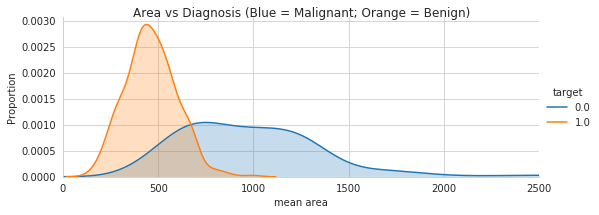

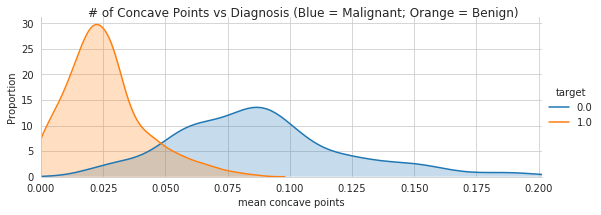

In [4]:
sns.set_style("whitegrid")
plotOne = sns.FacetGrid(sizeMeasurements, hue="target",aspect=2.5)
plotOne.map(sns.kdeplot,'mean area',shade=True)
plotOne.set(xlim=(0, sizeMeasurements['mean area'].max()))
plotOne.add_legend()
plotOne.set_axis_labels('mean area', 'Proportion')
plotOne.fig.suptitle('Area vs Diagnosis (Blue = Malignant; Orange = Benign)')
plt.show()

sns.set_style("whitegrid")
plotTwo = sns.FacetGrid(sizeMeasurements, hue="target",aspect=2.5)
plotTwo.map(sns.kdeplot,'mean concave points',shade= True)
plotTwo.set(xlim=(0, sizeMeasurements['mean concave points'].max()))
plotTwo.add_legend()
plotTwo.set_axis_labels('mean concave points', 'Proportion')
plotTwo.fig.suptitle('# of Concave Points vs Diagnosis (Blue = Malignant; Orange = Benign)')
plt.show()

*Step 4: Feature Selection*

Here we will compare three methods for feature selection: (1) No feature selection; (2) retain only features that are not correlated; (3) use PCA transformation to select features and reduce feature correlation.

(1) No feature selection


Feature Correlation:



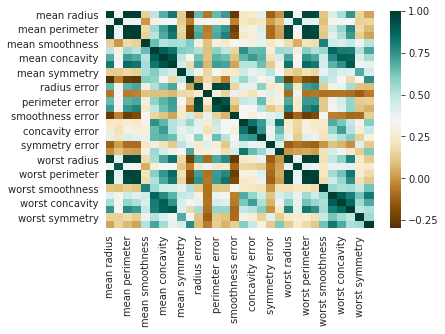

In [5]:
print("\nFeature Correlation:\n")
g = sns.heatmap(X_train.corr(),cmap="BrBG",annot=False)

(2) retain only features that are not correlated


 Feature Names: 

 ['mean texture' 'mean area' 'mean symmetry'] 


Feature Correlation:



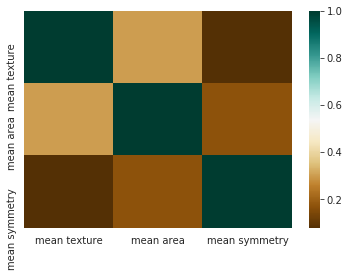

In [6]:
sizeMeasurements2 = sizeMeasurements.drop(['mean radius','mean perimeter',
 'mean smoothness', 'mean compactness', 'mean concavity',
 'mean concave points', 'mean fractal dimension',
 'radius error', 'texture error', 'perimeter error', 'area error',
 'smoothness error', 'compactness error', 'concavity error',
 'concave points error', 'symmetry error', 'fractal dimension error',
 'worst radius', 'worst perimeter', 
 'worst smoothness', 'worst compactness', 
 'worst concave points', 'worst symmetry', 'worst fractal dimension','worst texture', 'worst area',
 'worst concavity'], axis=1)
X2 = sizeMeasurements2[sizeMeasurements2.columns[:-1]]
y2 = sizeMeasurements2.target
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=0.2)
print('\n Feature Names: \n\n', X2.columns.values, "\n")
print("\nFeature Correlation:\n")
g = sns.heatmap(X_train2.corr(),cmap="BrBG",annot=False)

(3) use PCA transformation to select features and reduce feature correlation.


 Feature Names: 

 [0 1 2 3 4] 


Feature Correlation:



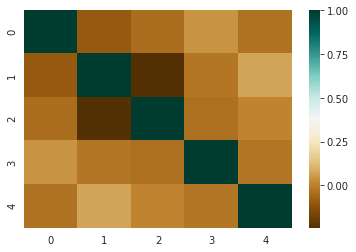

In [8]:
from sklearn.decomposition import PCA
X3=X
y3=y
variance_pct = 5 # Minimum percentage of variance we want to be described by the resulting transformed components
pca = PCA(n_components=variance_pct) # Create PCA object
X_transformed = pca.fit_transform(X3,y3) # Transform the initial features
X3pca = pd.DataFrame(X_transformed) #e a data frame from the PCA'd data
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3pca, y3, test_size=0.2)
print('\n Feature Names: \n\n', X3pca.columns.values, "\n")
#print('First Few Values, After PCA: \n\n,',X3pca.head(),'\n\n')
print("\nFeature Correlation:\n")
g = sns.heatmap(X_train3.corr(),cmap="BrBG",annot=False)

*Step 5: Evaluate Model Performance*

In [9]:
clf1 = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=12)
clf1.fit(X_train, Y_train)
clf2 = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=12)
clf2.fit(X_train2, Y_train2)
clf3 = tree.DecisionTreeClassifier(max_depth=3,min_samples_leaf=12)
clf3.fit(X_train3, Y_train3)
print('Accuracy of Decision Tree classifier on original training set: {:.2f}'.format(clf1.score(X_train, Y_train)))
print('Accuracy of Decision Tree classifier on original test set: {:.2f}'.format(clf1.score(X_test, Y_test)))
print('Accuracy of Decision Tree classifier on reduced training set: {:.2f}'.format(clf2.score(X_train2, Y_train2)))
print('Accuracy of Decision Tree classifier on reduced test set: {:.2f}'.format(clf2.score(X_test2, Y_test2)))
print('Accuracy of Decision Tree classifier on PCA-transformed training set: {:.2f}'.format(clf3.score(X_train3, Y_train3)))
print('Accuracy of Decision Tree classifier on PCA-transformed test set: {:.2f}'.format(clf3.score(X_test3, Y_test3)))

Accuracy of Decision Tree classifier on original training set: 0.95
Accuracy of Decision Tree classifier on original test set: 0.96
Accuracy of Decision Tree classifier on reduced training set: 0.92
Accuracy of Decision Tree classifier on reduced test set: 0.86
Accuracy of Decision Tree classifier on PCA-transformed training set: 0.95
Accuracy of Decision Tree classifier on PCA-transformed test set: 0.95


*Step 6: Explore Decision Trees*

(1) No feature selection

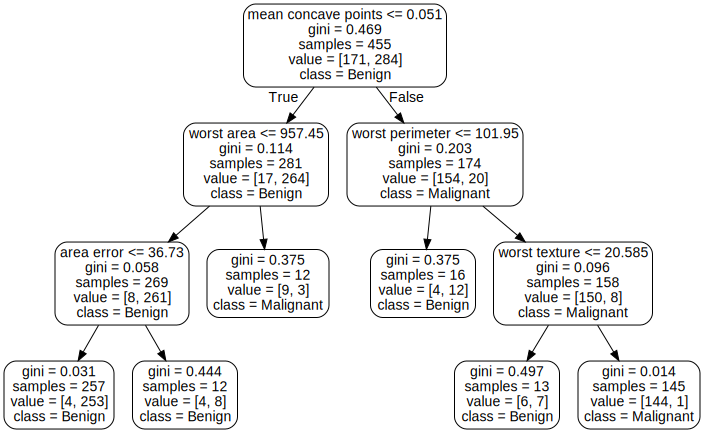

In [10]:
feature_names1 = X.columns.values
feature_names2 = X2.columns.values
feature_names3 = X3pca.columns.values

def plot_decision_tree1(a,b):
    dot_data = tree.export_graphviz(a, out_file=None, 
                             feature_names=b,  
                             class_names=['Malignant','Benign'],  
                             filled=False, rounded=True,  
                             special_characters=False)  
    graph = graphviz.Source(dot_data)  
    return graph 
plot_decision_tree1(clf1,feature_names1)

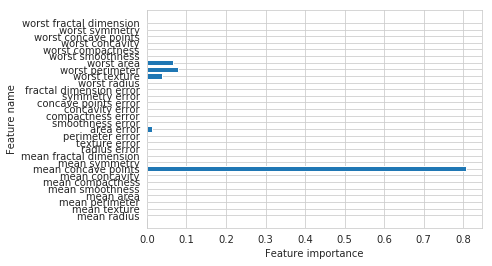

In [11]:
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)
plot_feature_importances(clf1, feature_names1)

(2) retain only features that are not correlated

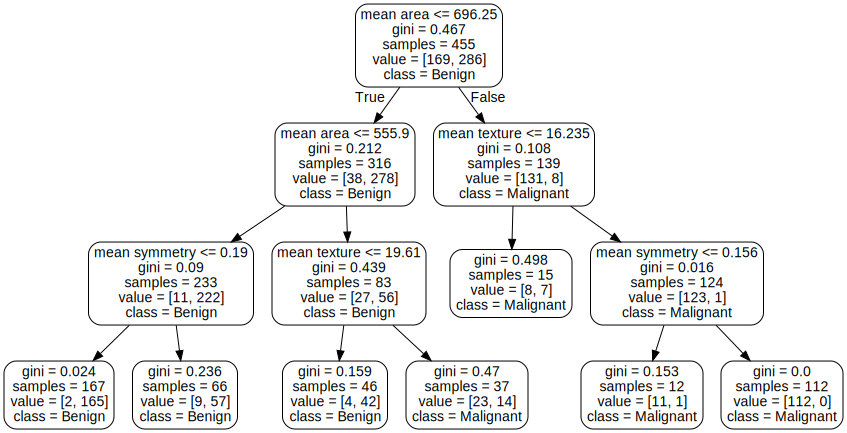

In [12]:
plot_decision_tree1(clf2,feature_names2)

(3) retain only features that were produced through PCA transformation.

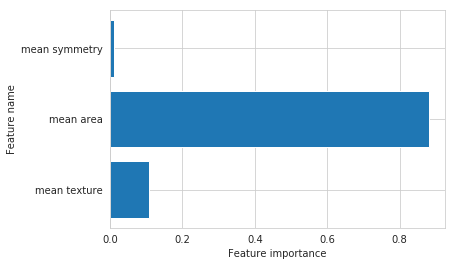

In [13]:
plot_feature_importances(clf2, feature_names2)
plt.show()

*Step 7: Define Helper Functions for Learning Curve and Confusion Matrix*

In [14]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: 'Malignant', 1: 'Benign'}

*Step 8: Evaluate Random Forest Classifier*

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy of Random Forest Classifier on training data: 1.00
Accuracy of Random Forest Classifier on testing data: 0.99


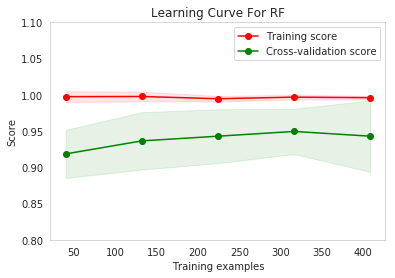

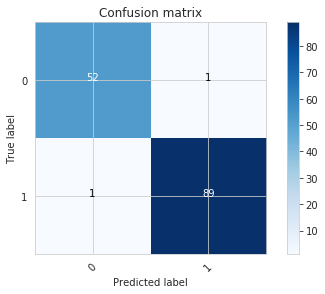

In [15]:
(X1, y1) = load_breast_cancer(return_X_y = True)
X_train1,X_test1,Y_train1,Y_test1=train_test_split(X1,y1,random_state=0)
clf = RandomForestClassifier(max_features=8,random_state=0)
clf.fit(X_train1,Y_train1)
print('Accuracy of Random Forest Classifier on training data: {:.2f}'.format(clf.score(X_train1,Y_train1)))
print('Accuracy of Random Forest Classifier on testing data: {:.2f}'.format(clf.score(X_test1,Y_test1)))
model = clf
prediction = model.predict(X_test1)
cnf_matrix = confusion_matrix(Y_test1, prediction)
plt.show()
plot_learning_curve(model, 'Learning Curve For RF', X_train, Y_train, (0.80,1.1), 10)
plt.show()
plot_confusion_matrix(cnf_matrix, classes=dict_characters,title='Confusion matrix')
plt.show()

Here we predict whether or not a sample is cancerous with an accuracy rate of 99%.

For a more detailed analysis, see the following link: https://www.kaggle.com/paultimothymooney/predicting-breast-cancer-from-nuclear-shape